In [300]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.metrics import accuracy_score
sns.set()
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
import lightgbm as lg
from scipy import stats
from sklearn.preprocessing import StandardScaler

In [159]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')
train.shape , test.shape

((381109, 12), (127037, 11))

## Important custom functions

In [160]:
def savePredictions(model,fileName,test_values):
    y_pred = model.predict_proba(test_values)[:,1]
    sub['Response'] = y_pred
    sub.to_csv(fileName+'.csv',index=False)
    return sub
scores = [0]

def getInfo(dataset):
    info = pd.DataFrame({'Nunuique':dataset.nunique(),'DataType':dataset.dtypes,'NullValues':dataset.isnull().sum()})
    return info

def preprocess(train):
    sc = StandardScaler()
    train = sc.fit_transform(train)
    return train


## Append train and test

In [161]:
#train = train[train.Annual_Premium < 200000]
#train['Annual_Premium']=np.log(train['Annual_Premium'])
#train = train.sample(frac=1).reset_index(drop=True)
raw_data = train.append(test)
raw_data.index = range(len(raw_data))

In [162]:
dataset = raw_data.copy()

## Mapping 

In [163]:
vehicle_age_map = {"> 2 Years":3,"1-2 Year":2,"< 1 Year":1}
dataset["Vehicle_Age"] = dataset["Vehicle_Age"].map(vehicle_age_map)

## Adding new features and binning

In [164]:
# adding new features and binning

l = []
for i in raw_data['Age']:
    if(i<25):l.append(1)
    elif(i>=25 and i<35):l.append(3)
    elif(i>=35 and i<50):l.append(4)
    elif(i>=50 and i<60):l.append(5)
    else:l.append(2)
dataset['Salary'] = l

Bins_Age = np.linspace(dataset['Age'].min(),dataset['Age'].max(),6)
Bins_Annual_Premium = np.linspace(dataset['Annual_Premium'].min(),dataset['Annual_Premium'].max(),4)
Bins_Vintage = np.linspace(dataset['Vintage'].min(),dataset['Vintage'].max(),4)

dataset['Experience_level'] =  pd.cut(dataset['Age'] , Bins_Age , labels=['one','two','three','four','five'],include_lowest=True)
dataset['Category_of_Annual_Premium'] =  pd.cut(dataset['Annual_Premium'] , Bins_Annual_Premium , labels=['low','medium','high'],include_lowest=True)
dataset['Time_of_Trust'] = pd.cut(dataset['Vintage'] , Bins_Vintage , labels=['short','average','long'],include_lowest=True)

transform_series = dataset.groupby('Vehicle_Age').size()/len(dataset)
dataset['Vehicle_Age_ratio']= dataset['Vehicle_Age'].apply(lambda x: transform_series[x])

transform_series = dataset.groupby('Policy_Sales_Channel').size()/len(dataset)
dataset['Policy_Sales_Channel_ratio']= dataset['Policy_Sales_Channel'].apply(lambda x: transform_series[x])


dataset['Experience_level'] =  pd.cut(dataset['Age'] , Bins_Age , labels=['one','two','three','four','five'],include_lowest=True)
dataset['Category_of_Annual_Premium'] =  pd.cut(dataset['Annual_Premium'] , Bins_Annual_Premium , labels=['low','medium','high'],include_lowest=True)

dataset['Annual_Premium']=np.log(dataset['Annual_Premium'])

In [8]:
#db = dataset.groupby(['Gender','Vehicle_Damage']).size() 
#db2 = dataset.groupby(['Gender']).size()
#dataset['Probab_previously_damage_per_gender'] = dataset['Gender'].apply(lambda x:db[x][1]/db2[x])

## Label Encode the columns

In [165]:
columns_to_be_label_encoded = ['Gender','Vehicle_Damage','Category_of_Annual_Premium','Experience_level','Time_of_Trust']
for col in columns_to_be_label_encoded:
    le = LabelEncoder()
    dataset[col] = le.fit_transform(dataset[col])

## Feature Engineering 

In [272]:
df = dataset.copy()

In [273]:
df['Damage_sums_per_region'] = df.groupby(['Region_Code'])['Vehicle_Damage'].transform('sum')
df['Mean_premium_per_region'] = df.groupby(['Region_Code'])['Annual_Premium'].transform('mean')
df['Count_unique_policy_sales_per_region'] = df.groupby(['Region_Code'])['Policy_Sales_Channel'].transform('nunique')
df['Count_policy_sales_per_region'] = df.groupby(['Region_Code'])['Policy_Sales_Channel'].transform('count')
df['Mean_vehicle_age_per_region'] = df.groupby(['Region_Code'])['Vehicle_Age'].transform('mean')
df['Mean_age_per_region'] = df.groupby(['Region_Code'])['Age'].transform('mean')
df['Mean_salary_per_region'] = df.groupby(['Region_Code'])['Salary'].transform('mean')
df['Count_previously_insured_per_region'] = df.groupby(['Region_Code'])['Previously_Insured'].transform('sum')
df['Mean_vintage_per_region'] = df.groupby(['Region_Code'])['Vintage'].transform('mean')
df['Max_premimum_per_region'] = df.groupby(['Region_Code'])['Annual_Premium'].transform('max')
df['Max_premimum_per_region'] = df.groupby(['Region_Code'])['Annual_Premium'].transform('min')
df["Rank_premium_per_region"] = df.groupby("Region_Code")['Annual_Premium'].rank(method="dense", ascending=True)


In [274]:
df['Mean_cat_premium_per_experience'] = df.groupby(["Experience_level"])['Category_of_Annual_Premium'].transform('mean')
df['Mean_premium_per_experience'] = df.groupby(["Experience_level"])['Annual_Premium'].transform('mean')
df['Mean_salary_per_experience'] = df.groupby(["Experience_level"])['Salary'].transform('mean')
#df['Mean_vehicle_damage_per_experience'] = df.groupby(["Experience_level"])['Vehicle_Damage'].transform('mean')
#df['Mean_vehicle_age_per_experience'] = df.groupby(["Experience_level"])['Vehicle_Age'].transform('mean')
#df['no_of_people_from_regionwise'] = df.groupby(['Region_Code'])['id'].transform('nunique')
#df['no_of_people_in_policy_channel'] = df.groupby(['Policy_Sales_Channel'])['id'].transform('count')
#df['no_of_people_with_same_associatedDays'] = df.groupby(['Vintage'])['id'].transform('count')

In [260]:
#df["RANK"] = df.groupby("Region_Code")['Region_Code'].rank(method="first", ascending=True)
#df["RANK_avg"] = df.groupby("Region_Code")['Region_Code'].rank(method="average", ascending=True)
#df["RANK_max"] = df.groupby("Region_Code")['Region_Code'].rank(method="max", ascending=True)
#df["RANK_min"] = df.groupby("Region_Code")['Region_Code'].rank(method="min", ascending=True)
#df["RANK_DIFF"] = df['RANK_max'] - df['RANK_min']

#df["RANK_Vehicle_Age"] = df.groupby(['Region_Code','Vehicle_Age'])['Region_Code'].rank(method='first',ascending=True)


In [216]:
policy_dict_map = df['Policy_Sales_Channel'].value_counts().to_dict()

#df['feaquency_count_policy']= df['Policy_Sales_Channel'].map(policy_dict_map)

In [232]:
from sklearn.feature_selection import VarianceThreshold
var_thresh = VarianceThreshold(threshold=0.1)
selector = var_thresh.fit(df)

df = df[df.columns[selector.get_support(indices=True)]]

In [275]:
df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,...,Mean_vehicle_age_per_region,Mean_age_per_region,Mean_salary_per_region,Count_previously_insured_per_region,Mean_vintage_per_region,Max_premimum_per_region,Rank_premium_per_region,Mean_cat_premium_per_experience,Mean_premium_per_experience,Mean_salary_per_experience
0,1,1,44,1,28.0,0,3,1,10.607921,26.0,...,1.916738,46.223536,3.422568,44166,154.266618,7.874739,17341.0,1.000221,9.928456,3.944646
1,2,1,76,1,3.0,0,2,0,10.420375,26.0,...,1.543040,36.980970,2.852053,6000,154.864442,7.874739,5260.0,1.000533,10.123132,2.000000
2,3,1,47,1,28.0,0,3,1,10.553049,26.0,...,1.916738,46.223536,3.422568,44166,154.266618,7.874739,15239.0,1.000326,9.999479,4.694271
3,4,1,21,1,11.0,1,1,0,10.261826,152.0,...,1.419127,34.235480,2.656716,7662,154.520360,7.874739,2961.0,1.000191,10.049680,1.939291
4,5,0,29,1,41.0,1,1,0,10.221796,152.0,...,1.501475,36.404016,2.869836,13820,154.851189,7.874739,3504.0,1.000191,10.049680,1.939291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508141,508142,0,26,1,37.0,1,1,0,10.337443,152.0,...,1.339916,32.467792,2.412366,3172,153.735122,7.874739,1964.0,1.000191,10.049680,1.939291
508142,508143,0,38,1,28.0,0,2,1,10.264652,122.0,...,1.916738,46.223536,3.422568,44166,154.266618,7.874739,5969.0,1.000221,9.928456,3.944646
508143,508144,1,21,1,46.0,1,1,0,10.302331,152.0,...,1.544865,37.140266,2.709375,13820,154.642676,7.874739,6767.0,1.000191,10.049680,1.939291
508144,508145,1,71,1,28.0,1,2,0,11.048904,26.0,...,1.916738,46.223536,3.422568,44166,154.266618,7.874739,34077.0,1.000402,10.048176,2.000000


In [293]:
#getInfo(df)

## Dividing into train and test 

In [305]:
train_df = df[df['Response'].isnull()==False]
test_df= df[df['Response'].isnull()==True]
X = train_df.drop(['Response','id'],axis=1)
y = train_df['Response'] 
X_pred =test_df.drop(['Response','id'],axis=1)
X.shape , y.shape , X_pred.shape

((381109, 30), (381109,), (127037, 30))

## train_test_split of the train and the test

In [288]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state =2020,stratify=y)
X_train.shape , X_test.shape , y_train.shape , y_test.shape  

((323942, 30), (57167, 30), (323942,), (57167,))

# Employing various Models for the classification Task

## 1) Lightgbm

In [294]:
lgb = lg.LGBMClassifier(boosting_type='gbdt',
                     n_estimators=450,learning_rate=0.0295,
                     objective='binary',metric='auc',is_unbalance=True,
                     colsample_bytree=0.5,reg_lambda=10,
                     reg_alpha=2,random_state=294,n_jobs=-1,seed=8798,max_depth=7 , max_bin=None,
                        early_stopping=20
                    )

In [295]:
lgb.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train, y_train)])

C:\Users\DELL\Miniconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's auc: 0.742962	valid_0's auc: 0.740566
Training until validation scores don't improve for 20 rounds
[2]	training's auc: 0.841237	valid_0's auc: 0.839023
[3]	training's auc: 0.848368	valid_0's auc: 0.84689
[4]	training's auc: 0.845824	valid_0's auc: 0.844199
[5]	training's auc: 0.848226	valid_0's auc: 0.846625
[6]	training's auc: 0.848688	valid_0's auc: 0.84734
[7]	training's auc: 0.851282	valid_0's auc: 0.849877
[8]	training's auc: 0.852922	valid_0's auc: 0.85162
[9]	training's auc: 0.853052	valid_0's auc: 0.851747
[10]	training's auc: 0.853661	valid_0's auc: 0.852427
[11]	training's auc: 0.854018	valid_0's auc: 0.852689
[12]	training's auc: 0.854218	valid_0's auc: 0.852908
[13]	training's auc: 0.854118	valid_0's auc: 0.85283
[14]	training's auc: 0.854247	valid_0's auc: 0.852945
[15]	training's auc: 0.854412	valid_0's auc: 0.853084
[16]	training's auc: 0.854565	valid_0's auc: 0.853175
[17]	training's auc: 0.85495	valid_0's auc: 0.853579
[18]	training's auc: 0.854853	valid

[152]	training's auc: 0.860329	valid_0's auc: 0.857575
[153]	training's auc: 0.860358	valid_0's auc: 0.857582
[154]	training's auc: 0.860376	valid_0's auc: 0.857576
[155]	training's auc: 0.860391	valid_0's auc: 0.857587
[156]	training's auc: 0.860409	valid_0's auc: 0.857592
[157]	training's auc: 0.860426	valid_0's auc: 0.857603
[158]	training's auc: 0.860439	valid_0's auc: 0.857615
[159]	training's auc: 0.860462	valid_0's auc: 0.857629
[160]	training's auc: 0.860474	valid_0's auc: 0.857626
[161]	training's auc: 0.8605	valid_0's auc: 0.857648
[162]	training's auc: 0.860526	valid_0's auc: 0.85765
[163]	training's auc: 0.86054	valid_0's auc: 0.857647
[164]	training's auc: 0.860558	valid_0's auc: 0.857657
[165]	training's auc: 0.860572	valid_0's auc: 0.857662
[166]	training's auc: 0.8606	valid_0's auc: 0.857683
[167]	training's auc: 0.860646	valid_0's auc: 0.857724
[168]	training's auc: 0.860667	valid_0's auc: 0.857729
[169]	training's auc: 0.860685	valid_0's auc: 0.857734
[170]	training's

[302]	training's auc: 0.862507	valid_0's auc: 0.858436
[303]	training's auc: 0.86251	valid_0's auc: 0.858434
[304]	training's auc: 0.862513	valid_0's auc: 0.858436
[305]	training's auc: 0.862515	valid_0's auc: 0.858434
[306]	training's auc: 0.862516	valid_0's auc: 0.858436
[307]	training's auc: 0.862519	valid_0's auc: 0.858434
[308]	training's auc: 0.862531	valid_0's auc: 0.858437
[309]	training's auc: 0.862545	valid_0's auc: 0.858434
[310]	training's auc: 0.862548	valid_0's auc: 0.858433
[311]	training's auc: 0.862566	valid_0's auc: 0.858425
[312]	training's auc: 0.86259	valid_0's auc: 0.858434
[313]	training's auc: 0.862609	valid_0's auc: 0.858442
[314]	training's auc: 0.862616	valid_0's auc: 0.858447
[315]	training's auc: 0.862619	valid_0's auc: 0.858446
[316]	training's auc: 0.862634	valid_0's auc: 0.858452
[317]	training's auc: 0.862637	valid_0's auc: 0.858453
[318]	training's auc: 0.862639	valid_0's auc: 0.858454
[319]	training's auc: 0.862669	valid_0's auc: 0.858459
[320]	traini

LGBMClassifier(colsample_bytree=0.5, early_stopping=20, is_unbalance=True,
               learning_rate=0.0295, max_bin=None, max_depth=7, metric='auc',
               n_estimators=450, objective='binary', random_state=294,
               reg_alpha=2, reg_lambda=10, seed=8798)

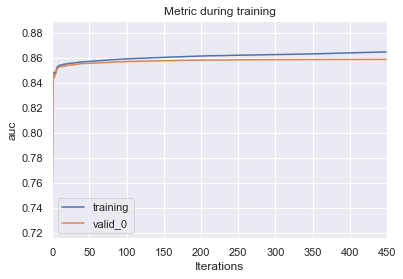

In [296]:
lg.plot_metric(lgb)

In [297]:
score = roc_auc_score(y_test,lgb.predict_proba(X_test,lgb.best_iteration_)[:,1])
scores.append(score)
print(scores)

[0, 0.8585388068299891, 0.8584525622460182, 0.8583868882313859, 0.858399842354046, 0.858580474549374, 0.8583973599310237, 0.8586632694031873]


In [306]:
sub = savePredictions(lgb,'LightGBM',X_pred)
sub

,id,Response
0,381110,0.004269
1,381111,0.769540
2,381112,0.739819
3,381113,0.052382
4,381114,0.002757
...,...,...
127032,508142,0.003379
127033,508143,0.795874
127034,508144,0.001413
127035,508145,0.001899


In [76]:
l=[8907 , 567 , 3412 , 2030]
for i in l:
    lgb = lg.LGBMClassifier(boosting_type='gbdt',
                     n_estimators=450,depth=10,learning_rate=0.03,
                     objective='binary',metric='auc',is_unbalance=True,
                     colsample_bytree=0.5,reg_lambda=10,
                     reg_alpha=2,random_state=294,n_jobs=-1,seed=i,max_depth=7
                    )
    lgb.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train, y_train)],verbose=False)
    score = roc_auc_score(y_test,lgb.predict_proba(X_test)[:,1])
    print(score)

0.8549061261818001
0.85496873804751
0.8549006389585317
0.8549746623692587


In [95]:
l=[None,20,60,100,200]
for i in l:
    lgb = lg.LGBMClassifier(boosting_type='gbdt',
                     n_estimators=450,depth=10,learning_rate=0.03,
                     objective='binary',metric='auc',is_unbalance=True,
                     colsample_bytree=0.5,reg_lambda=10,
                     reg_alpha=2,random_state=294,n_jobs=-1,seed=2030,max_depth=7,max_bin=i
                    )
    lgb.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train, y_train)],verbose=False)
    score = roc_auc_score(y_test,lgb.predict_proba(X_test)[:,1])
    print(score)

0.8583244464011723
0.8581546628923595
0.8583447226048047
0.8582845242021591
0.8583022482757616


In [114]:
l=[-1,10,20,7,4]
for i in l:
    lgb = lg.LGBMClassifier(boosting_type='gbdt',
                     n_estimators=450,depth=10,learning_rate=0.03,
                     objective='binary',metric='auc',is_unbalance=True,
                     colsample_bytree=0.5,reg_lambda=10,
                     reg_alpha=2,random_state=294,n_jobs=-1,seed=2030,max_depth=i,max_bin=None
                    )
    lgb.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train, y_train)],verbose=False)
    score = roc_auc_score(y_test,lgb.predict_proba(X_test)[:,1])
    print(score)

0.8583545171506552
0.8584067291218693
0.8583545171506552
0.858419037387766
0.8576926192399534


In [285]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile

ufs = SelectKBest(chi2,k=25)
ufs.fit(X, y)
X_transformed = ufs.transform(X)
X_pred = ufs.transform(X_pred)

In [251]:


from sklearn.feature_selection import SelectFromModel
col_names = X.columns

lgb = lg.LGBMClassifier(boosting_type='gbdt',
                     n_estimators=450,learning_rate=0.0285,
                     objective='binary',metric='auc',is_unbalance=True,
                     colsample_bytree=0.5,reg_lambda=10,
                     reg_alpha=2,random_state=294,n_jobs=-1,seed=8798,max_depth=7 , max_bin=None)
sfm = SelectFromModel(estimator=lgb)
X_transformed = sfm.fit_transform(X, y)
# see which features were selected
support = sfm.get_support()
# get feature names
print([
 x for x, y in zip(col_names, support) if y == True
])

['Age', 'Region_Code', 'Vehicle_Age', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Mean_premium_per_region', 'Mean_age_per_region', 'Mean_salary_per_region', 'Rank_premium_per_region']


In [253]:
cols=['Age', 'Region_Code', 'Vehicle_Age', 'Annual_Premium', 'Policy_Sales_Channel', 
      'Vintage', 'Mean_premium_per_region', 'Mean_age_per_region', 'Mean_salary_per_region', 'Rank_premium_per_region']
train_df = df[df['Response'].isnull()==False]
test_df= df[df['Response'].isnull()==True]

X = train_df[cols]
y = train_df['Response'] 
X_pred =test_df[cols]

X.shape , X_pred.shape

((381109, 10), (127037, 10))

In [254]:
lgb = lg.LGBMClassifier(boosting_type='gbdt',
                     n_estimators=450,learning_rate=0.0295,
                     objective='binary',metric='auc',is_unbalance=True,
                     colsample_bytree=0.5,reg_lambda=10,
                     reg_alpha=2,random_state=294,n_jobs=-1,seed=8798,max_depth=7 , max_bin=None)
lgb.fit(X,y)
py = lgb.predict_proba(X_pred)[:,1]
sub = savePredictions(lgb,'LightGBM',X_pred)

In [312]:
features = list(X.columns)

param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

folds = StratifiedKFold(n_splits=5, shuffle=False, random_state=44000)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    print("Fold {}".format(fold_))
    trn_data = lg.Dataset(X.iloc[trn_idx][features], label=y.iloc[trn_idx])
    val_data = lg.Dataset(X.iloc[val_idx][features], label=y.iloc[val_idx])

    num_round = 10000
    clf = lg.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(X_pred, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

C:\Users\DELL\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Fold 0
Training until validation scores don't improve for 3000 rounds
[1000]	training's auc: 0.846572	valid_1's auc: 0.84689
[2000]	training's auc: 0.857183	valid_1's auc: 0.855992
[3000]	training's auc: 0.859843	valid_1's auc: 0.857685
[4000]	training's auc: 0.861133	valid_1's auc: 0.858086
[5000]	training's auc: 0.862084	valid_1's auc: 0.858278
[6000]	training's auc: 0.862823	valid_1's auc: 0.858364
[7000]	training's auc: 0.863516	valid_1's auc: 0.858388
[8000]	training's auc: 0.864059	valid_1's auc: 0.858358
[9000]	training's auc: 0.864629	valid_1's auc: 0.858288
Early stopping, best iteration is:
[6788]	training's auc: 0.863363	valid_1's auc: 0.858407
Fold 1
Training until validation scores don't improve for 3000 rounds
[1000]	training's auc: 0.8466	valid_1's auc: 0.846786
[2000]	training's auc: 0.857148	valid_1's auc: 0.856163
[3000]	training's auc: 0.859842	valid_1's auc: 0.857967
[4000]	training's auc: 0.86117	valid_1's auc: 0.858395
[5000]	training's auc: 0.862125	valid_1's auc

NameError: name 'target' is not defined

In [313]:
print("CV score: {:<8.5f}".format(roc_auc_score(target.iloc[val_idx], oof)))

NameError: name 'target' is not defined

In [315]:
sub["Response"] = predictions
sub.to_csv("last.csv", index=False)